# IMPORTING LIBRARIES

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from transformers import (
    AutoProcessor,
    PaliGemmaForConditionalGeneration
)

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw, ImageFont

c:\Users\adith\anaconda3\envs\MultiModal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DEFINING MODEL WITH PARAMETERS

In [2]:
model_id = "google/paligemma-3b-mix-224"

device = "cuda:0"
dtype = torch.bfloat16

batch_size = 1
learning_rate = 5e-5

processor = AutoProcessor.from_pretrained(model_id)

# SUPPPORT FUNCTIONS FOR DATA LOADING

In [ ]:
import json

def data_creator(path):

    # Load the .jsonl file
    file_path = path

    # Read the file line by line into a list
    data = []
    with open(file_path, "r") as f:
        for line in f:
            data.append(json.loads(line))

    # Check the first few entries
    return data

training_objects = data_creator("dataset\_annotations.train.jsonl")
validation_objects = data_creator("dataset\_annotations.valid.jsonl")
test_objects = data_creator("dataset\_annotations.test.jsonl")

In [4]:
# Define collate function
def collate_train_fn(examples):
    # Load and convert images to RGB
    image = [Image.open(example["image"]) for example in examples]

    # Define prompt and suffix
    prompt = ["<image> " + example["prefix"] for example in examples]

    suffix = [example["suffix"] for example in examples]

    # Tokenize inputs using a Hugging Face processor
    inputs = processor(
        images=image,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

def collate_test_fn(examples):
    image = [Image.open(example["image"]) for example in examples]

    prompt = ["<image> " + example["prefix"] for example in examples]

    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

# DEFINING DATA LOADER FOR TRAIN, VAL AND TEST

In [5]:
# Initialize the dataset and dataloader

train_dataloader = DataLoader(
    training_objects,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)


validation_dataloader = DataLoader(
    validation_objects,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)


test_dataloader = DataLoader(
    test_objects,
    collate_fn=collate_test_fn,
    batch_size=batch_size,
    shuffle=False,
)

# MODEL INITIALIZATION

In [6]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


# SELECTING LAYERS FOR FINETUNING

In [7]:
for name, param in model.named_parameters():
    if "attn" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in model.named_parameters():
    print(f"{name:<70}: requires_grad={param.requires_grad}, dtype={param.dtype}")

vision_tower.vision_model.embeddings.patch_embedding.weight           : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.patch_embedding.bias             : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.embeddings.position_embedding.weight        : requires_grad=False, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias      : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.weight    : requires_grad=True, dtype=torch.bfloat16
vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.bias      : requires_grad=True, d

In [8]:
val_batch = next(iter(validation_dataloader))
test_batch = next(iter(test_dataloader))

In [9]:
print(f"{val_batch.keys()=}")
print(f"{test_batch.keys()=}")

val_batch.keys()=dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'labels'])
test_batch.keys()=dict_keys(['input_ids', 'attention_mask', 'pixel_values'])


In [10]:
outputs = model(**val_batch)
print(f"{outputs.loss=}")

outputs.loss=tensor(3.2414, device='cuda:0', grad_fn=<NllLossBackward0>)


# INFERENCE WITHOUT TRAINING

In [11]:
with torch.inference_mode():
    generation = model.generate(**test_batch, max_new_tokens=100, do_sample=False)
    decoded = processor.batch_decode(generation, skip_special_tokens=True)

In [12]:
for element in decoded:
    location = element.split("\n")[1]
    if location == "":
        print("No bbox found")
    else:
        print(location)

<loc0000><loc0000><loc1023><loc1019> Test ; <loc0291><loc0717><loc0422><loc0934> Control-Panel ; <loc0842><loc0710><loc1023><loc1023> Gate Valve ; <loc0866><loc0713><loc1023><loc1023> Valve ; <loc0000><loc0000><loc1023><loc1019> Menger ; <loc0368><loc0759><loc0424><loc0899> Orifice ; <loc0311><loc0522><loc0399><loc0562> Valve ; <loc0311><loc0717><loc0422><loc0933> Closed Valve ; <loc0000><loc0000><loc1023><loc1019> Test ; <loc0000><loc0000><loc1023><loc1019> Test ; <loc0000><loc0000><loc1023><loc1018> Test ; <loc0000><loc0000><loc1023><loc1018> Test ; <loc0000><loc0000><loc1023><loc1018> Test ; <loc0000><loc0000><loc1023>


# FINETUNING THE ATTENTION LAYERS OF THE MODEL

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        print(f"Epoch: {epoch} Iter: {idx} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0 Iter: 0 Loss: 2.9285
Epoch: 0 Iter: 1 Loss: 3.1779
Epoch: 0 Iter: 2 Loss: 2.4276
Epoch: 0 Iter: 3 Loss: 2.7007
Epoch: 0 Iter: 4 Loss: 2.2570
Epoch: 0 Iter: 5 Loss: 2.2167
Epoch: 0 Iter: 6 Loss: 3.3223
Epoch: 0 Iter: 7 Loss: 2.3015
Epoch: 0 Iter: 8 Loss: 2.0919
Epoch: 0 Iter: 9 Loss: 2.5916
Epoch: 0 Iter: 10 Loss: 2.2017
Epoch: 0 Iter: 11 Loss: 2.1284
Epoch: 0 Iter: 12 Loss: 3.1238
Epoch: 0 Iter: 13 Loss: 1.9006
Epoch: 0 Iter: 14 Loss: 2.1700
Epoch: 0 Iter: 15 Loss: 2.0933
Epoch: 0 Iter: 16 Loss: 2.7557
Epoch: 0 Iter: 17 Loss: 2.8465
Epoch: 0 Iter: 18 Loss: 3.2706
Epoch: 0 Iter: 19 Loss: 2.3802
Epoch: 0 Iter: 20 Loss: 2.4147
Epoch: 0 Iter: 21 Loss: 2.1908
Epoch: 0 Iter: 22 Loss: 2.2696
Epoch: 0 Iter: 23 Loss: 2.1587
Epoch: 0 Iter: 24 Loss: 2.2087
Epoch: 0 Iter: 25 Loss: 2.3062
Epoch: 0 Iter: 26 Loss: 2.5634
Epoch: 0 Iter: 27 Loss: 2.6944
Epoch: 0 Iter: 28 Loss: 2.5155
Epoch: 0 Iter: 29 Loss: 2.1979
Epoch: 0 Iter: 30 Loss: 4.4602
Epoch: 0 Iter: 31 Loss: 2.2950
Epoch: 0 Iter: 32 

# HELPER FUNCTIONS FOR POST PROCESSING OF RESULTS

In [14]:
DETECT_RE = re.compile(r"(<loc\d{4}><loc\d{4}><loc\d{4}><loc\d{4}>)\s*([^;<>]+)", )

In [15]:
def extract_objects(detection_string, image_width, image_height, unique_labels=False):
    objects = []
    seen_labels = set()

    matches = DETECT_RE.findall(detection_string)

    detections = []

    for match in matches:
        locations, label = match[0], match[1]
        print(locations)
        locations = locations.replace("<loc","").replace(">", " ").split(" ")
        locations.pop()
        y_min, x_min, y_max, x_max = map(int,locations)
        bbox = [y_min, x_min, y_max, x_max]
        detections.append((bbox, label))

    return detections

In [16]:
def normalize_coordinates(bbox, img_width, img_height):
    y_min, x_min, y_max, x_max = bbox
    return [
        y_min * img_height / 1024,
        x_min * img_width / 1024,
        y_max * img_height / 1024,
        x_max * img_width / 1024
    ]

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(image, detections):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for bbox, label in detections:
        normalized_bbox = normalize_coordinates(bbox, image.shape[0], image.shape[1])
        y_min, x_min, y_max, x_max = normalized_bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, label, color='r', fontweight='bold')
    
    plt.show()

# PERFORMING THE INFERENCE ON TEST DATASET

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([224, 224, 3])
<loc0326><loc0350><loc0472><loc0484>
<loc0207><loc0578><loc0350><loc0707>
<loc0207><loc0094><loc0318><loc0180>
<loc0188><loc0236><loc0306><loc0360>
<loc0188><loc0368><loc0306><loc0479>
<loc0188><loc0786><loc0290><loc0890>
<loc0188><loc0054><loc0306><loc0164>
<loc0188><loc0153><loc0306><loc0269>
<loc0188><loc0000><loc0244><loc0014>
<loc0480><loc0796><loc0600><loc0902>
<loc0480><loc0796><loc0600><loc0902>


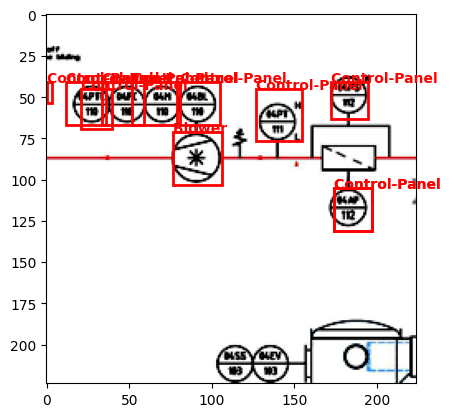

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([224, 224, 3])
<loc0522><loc0102><loc0600><loc0172>
<loc0522><loc0698><loc0594><loc0750>
<loc0740><loc0480><loc0852><loc0558>
<loc0740><loc0113><loc0852><loc0224>
<loc0786><loc0125><loc0875><loc0224>
<loc0786><loc0714><loc0875><loc0794>
<loc0786><loc0461><loc0860><loc0552>
<loc0740><loc0572><loc0846><loc0640>
<loc0740><loc0642><loc0852><loc0756>
<loc0740><loc0642><loc0852><loc0743>
<loc0875><loc0572><loc0968><loc0646>


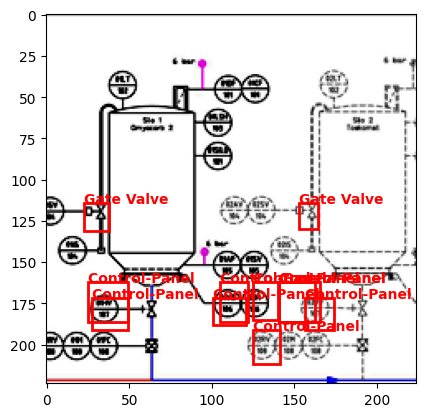

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.953125..1.0].


torch.Size([224, 224, 3])
<loc0740><loc0490><loc0870><loc0592>
<loc0740><loc0000><loc0867><loc0102>
<loc0740><loc0102><loc0867><loc0212>
<loc0592><loc0097><loc0662><loc0204>
<loc0592><loc0085><loc0662><loc0189>
<loc0654><loc0112><loc0756><loc0212>
<loc0640><loc0011><loc0770><loc0120>
<loc0758><loc0000><loc0867><loc0102>
<loc0786><loc0000><loc0876><loc0102>
<loc0763><loc0000><loc0867><loc0102>
<loc0740><loc0000><loc0867><loc0102>


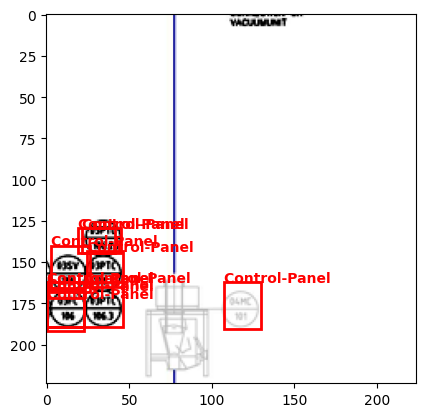

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([224, 224, 3])
<loc0698><loc0510><loc0786><loc0580>
<loc0306><loc0947><loc0421><loc1023>
<loc0698><loc0742><loc0786><loc0826>
<loc0698><loc0630><loc0794><loc0723>
<loc0698><loc0112><loc0875><loc0244>
<loc0258><loc0121><loc0369><loc0232>
<loc0875><loc0145><loc1023><loc0269>
<loc0875><loc0043><loc1023><loc0172>
<loc0472><loc0120><loc0576><loc0231>
<loc0698><loc0000><loc0869><loc0030>
<loc0698><loc0000><loc0852><loc0030>


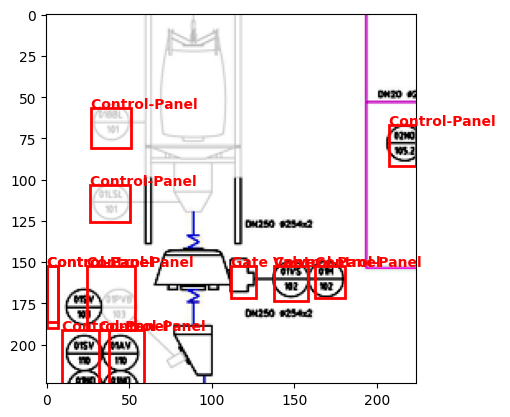

In [17]:
for idx, batch in enumerate(test_dataloader):

    with torch.inference_mode():
        generation = model.generate(**batch, max_new_tokens=100, do_sample=False)
        decoded = processor.batch_decode(generation, skip_special_tokens=True)

    image = batch["pixel_values"][0].permute(1, 2, 0).cpu().float()
    print(image.shape)
    element = decoded[0]
    detection_string = element.split("\n")[1]
    objects = extract_objects(detection_string, 224, 224, unique_labels=False)
    plot_detections(image, objects)